In [1]:
import numpy as np
import pandas as pd

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
train_path = 'news-train-1.csv'
test_path = 'news-test.csv'
dictionary_path = 'dictionary.txt'

In [3]:
train_df = pd.read_csv(train_path)
labels = train_df['Category'].unique().tolist()
test_df = pd.read_csv(test_path)
vocab = pd.read_csv(dictionary_path, header=None)[0].tolist()

In [4]:
print("Number of Train samples = ", train_df.shape[0])
print("Number of Test samples = ", test_df.shape[0])
print("Vocabulary size = ", len(vocab))
print("Number of instances for each label:")
display(train_df[['ArticleId', 'Category']].groupby(by='Category').agg('count'))

Number of Train samples =  1063
Number of Test samples =  735
Vocabulary size =  1000
Number of instances for each label:


,ArticleId
Category,
business,237
entertainment,193
politics,200
sport,246
tech,187


In [5]:
stemmer = PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def get_tokens(text):
    """
        Perform lowercase, punctuation and stopword removal, tokenization
        and finally stemming to get tokens from given text
    """
    lowers = text.lower()
    no_punctuation = lowers.translate(remove_punctuation_map)
    tokens = nltk.word_tokenize(no_punctuation)
    filtered = [w for w in tokens if not w in stopwords.words("english")]
    stemmed = []
    for item in filtered:
        stemmed.append(stemmer.stem(item))

    return stemmed

In [6]:
def get_topk_words(freq_mat, k, category_wise=True):
    """
        Get top K words based on frequency counts to
        select important words.
        Category-wise gives top k * (# Categories)
        distinct words
    """
    if not category_wise:
        return np.argpartition(freq_mat, -k)[-k:]
    words = []
    for l in labels:
        words.extend(np.argpartition(freq_mat[train_df['Category'] == l].mean(axis=0), -k)[-k:].tolist())
    return list(set(words))

In [7]:
# Using unigrams and bigrams
tf = CountVectorizer(tokenizer=get_tokens, vocabulary=vocab, ngram_range=(1, 2))
train_tf = tf.fit_transform(train_df['Text']).toarray()
test_tf = tf.transform(test_df['Text']).toarray()

tfidf = TfidfVectorizer(tokenizer=get_tokens, vocabulary=vocab, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train_df['Text']).toarray()
test_tfidf = tfidf.transform(test_df['Text']).toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Define NN function

In [8]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from sklearn.model_selection import KFold
import torch.optim as optim
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, num_features):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(num_features, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def train_evaluate_model(X, y, optimizer_name, num_epochs, batch_size, learning_rate):
    X_tensor = torch.FloatTensor(X)

    categories, category_mapping = y.factorize()
    y_tensor = torch.LongTensor(categories)

    dataset = TensorDataset(X_tensor, y_tensor)

    criterion = nn.CrossEntropyLoss()
    kfold = KFold(n_splits=5, shuffle=True)

    train_accuracies = []
    val_accuracies = []

    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        print(f'FOLD {fold+1}')
        print('--------------------------------')

        train_subsampler = SubsetRandomSampler(train_ids)
        test_subsampler = SubsetRandomSampler(test_ids)

        trainloader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        testloader = DataLoader(dataset, batch_size=batch_size, sampler=test_subsampler)

        final_model = SimpleNN(num_features=X.shape[1])

        if optimizer_name.lower() == 'adam':
            optimizer = optim.Adam(final_model.parameters(), lr=learning_rate)
        elif optimizer_name.lower() == 'sgd':
            optimizer = optim.SGD(final_model.parameters(), lr=learning_rate)
        elif optimizer_name.lower() == 'rmsprop':
            optimizer = optim.RMSprop(final_model.parameters(), lr=learning_rate)
        elif optimizer_name.lower() == 'adagrad':
            optimizer = optim.Adagrad(final_model.parameters(), lr=learning_rate)
        elif optimizer_name.lower() == 'adamw':
            optimizer = optim.AdamW(final_model.parameters(), lr=learning_rate)
        else:
            raise ValueError('Invalid optimizer name')

        fold_train_accuracies = []

        for epoch in range(num_epochs):
            final_model.train()
            train_correct, train_total = 0, 0
            for data in trainloader:
                features, labels = data
                optimizer.zero_grad()
                predictions = final_model(features)
                loss = criterion(predictions, labels)
                loss.backward()
                optimizer.step()
                _, top_prediction = torch.max(predictions, 1)
                num_correct = (top_prediction == labels).sum().item()
                train_correct += num_correct
                train_total += labels.size(0)

            train_accuracy = 100.0 * train_correct / train_total
            train_accuracies.append(train_accuracy)
            print(f'Epoch {epoch+1}: Training Accuracy: {train_accuracy:.2f}%')

        final_model.eval()
        correct, total = 0, 0

        with torch.no_grad():
            for inputs, targets in testloader:
                outputs = final_model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        val_accuracy = 100.0 * correct / total
        val_accuracies.append(val_accuracy)
        print(f'Validation Accuracy: {val_accuracy:.2f}%')
        print('--------------------------------')
        print()

    # Final evaluation
    print(f'Average training accuracy: {np.mean(train_accuracies):.2f}%')
    print(f'Std of training accuracy: {np.std(train_accuracies):.2f}%')
    print(f'Average validation accuracy: {np.mean(val_accuracies):.2f}%')
    print(f'Std of validation accuracy: {np.std(val_accuracies):.2f}%')

    return [train_accuracies, val_accuracies], category_mapping, final_model

1.a Run Neural Networks with the 2-hidden layers, each has 128 neurons, extracting features by CountVectorizer() as the original features. Use 5-fold cross-validation to evaluate the performance.

In [9]:
y = train_df['Category']
features = np.arange(len(vocab))

train_mat, test_mat = train_tf, test_tf


X_train_countvectorizer = train_mat[:, features]
X_test_countvectorizer = test_mat[:, features]

Using TFIDF

In [10]:
train_mat, test_mat = train_tfidf, test_tfidf

X_train_tfidif = train_mat[:, features]
X_test_tfidif = test_mat[:, features]

Using BERT

In [11]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.5 MB/s eta 0:00:00


In [12]:
from transformers import BertModel, BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def generate_bert_embeddings(texts):
    model.eval()
    all_embeddings = []

    for text in texts:
        with torch.no_grad():
            inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
            outputs = model(**inputs)

        embeddings = outputs.last_hidden_state
        embeddings = embeddings.mean(dim=1)
        all_embeddings.append(embeddings)

    all_embeddings = torch.cat(all_embeddings, dim=0)
    return all_embeddings.numpy()

bert_embeddings = generate_bert_embeddings(train_df['Text'])
bert_embeddings_test = generate_bert_embeddings(test_df['Text'])

In [13]:
print(bert_embeddings.shape)
print(bert_embeddings_test.shape)

(1063, 768)
(735, 768)


In [14]:
X_bert = bert_embeddings
X_test_bert = bert_embeddings_test

Report the average training and validation accuracy, and their standard deviation for different feature construction (organize the results in a table).

In [35]:
countvectorizer_res, category_map, final_model = train_evaluate_model(X_train_countvectorizer, y, optimizer_name="adamw", num_epochs=50, batch_size=32, learning_rate=0.001)
tfidf_res, category_map, final_model = train_evaluate_model(X_train_tfidif, y, optimizer_name="adamw", num_epochs=50, batch_size=32, learning_rate=0.001)
bert_res, category_map, final_model = train_evaluate_model(X_bert, y, optimizer_name="adamw", num_epochs=50, batch_size=32, learning_rate=0.001)

FOLD 1
--------------------------------
Epoch 1: Training Accuracy: 74.82%
Epoch 2: Training Accuracy: 97.18%
Epoch 3: Training Accuracy: 99.76%
Epoch 4: Training Accuracy: 100.00%
Epoch 5: Training Accuracy: 100.00%
Epoch 6: Training Accuracy: 100.00%
Epoch 7: Training Accuracy: 100.00%
Epoch 8: Training Accuracy: 100.00%
Epoch 9: Training Accuracy: 100.00%
Epoch 10: Training Accuracy: 100.00%
Epoch 11: Training Accuracy: 100.00%
Epoch 12: Training Accuracy: 100.00%
Epoch 13: Training Accuracy: 100.00%
Epoch 14: Training Accuracy: 100.00%
Epoch 15: Training Accuracy: 100.00%
Epoch 16: Training Accuracy: 100.00%
Epoch 17: Training Accuracy: 100.00%
Epoch 18: Training Accuracy: 100.00%
Epoch 19: Training Accuracy: 100.00%
Epoch 20: Training Accuracy: 100.00%
Epoch 21: Training Accuracy: 100.00%
Epoch 22: Training Accuracy: 100.00%
Epoch 23: Training Accuracy: 100.00%
Epoch 24: Training Accuracy: 100.00%
Epoch 25: Training Accuracy: 100.00%
Epoch 26: Training Accuracy: 100.00%
Epoch 27: 

In [36]:
data = {
    "Feature": ["CountVectorizer()", "TFIDF", "BERT"],
    "Avg training acc.": [
        sum(countvectorizer_res[0]) / len(countvectorizer_res[0]),
        sum(tfidf_res[0]) / len(tfidf_res[0]),
        sum(bert_res[0]) / len(bert_res[0]),
    ],
    "Std training acc.": [
        pd.Series(countvectorizer_res[0]).std(),
        pd.Series(tfidf_res[0]).std(),
        pd.Series(bert_res[0]).std(),
    ],
    "Avg validation acc.": [
        sum(countvectorizer_res[1]) / len(countvectorizer_res[1]),
        sum(tfidf_res[1]) / len(tfidf_res[1]),
        sum(bert_res[1]) / len(bert_res[1]),
    ],
    "Std validation acc.": [
        pd.Series(countvectorizer_res[1]).std(),
        pd.Series(tfidf_res[1]).std(),
        pd.Series(bert_res[1]).std(),
    ],
}

df = pd.DataFrame(data)

display(df)

,Feature,Avg training acc.,Std training acc.,Avg validation acc.,Std validation acc.
0,CountVectorizer(),99.437931,3.587708,96.235273,1.060216
1,TFIDF,98.602632,7.861738,96.989990,0.533007
2,BERT,98.957681,4.965461,98.212862,0.902619


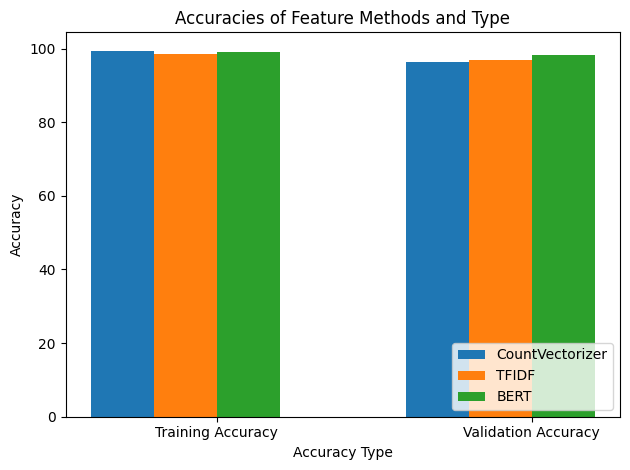

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


avg_countvectorizer_train_acc = sum(countvectorizer_res[0]) / len(countvectorizer_res[0])
avg_countvectorizer_val_acc = sum(countvectorizer_res[1]) / len(countvectorizer_res[1])

avg_tfidf_train_acc = sum(tfidf_res[0]) / len(tfidf_res[0])
avg_tfidf_val_acc = sum(tfidf_res[1]) / len(tfidf_res[1])

avg_bert_train_acc = sum(bert_res[0]) / len(bert_res[0])
avg_bert_val_acc = sum(bert_res[1]) / len(bert_res[1])

data = {
    'Accuracy Type': ['Training Accuracy', 'Validation Accuracy'],
    'CountVectorizer': [avg_countvectorizer_train_acc, avg_countvectorizer_val_acc],
    'TFIDF': [avg_tfidf_train_acc, avg_tfidf_val_acc],
    'BERT': [avg_bert_train_acc, avg_bert_val_acc]
}

labels = data['Accuracy Type']
methods_data = [data[method] for method in data if method != 'Accuracy Type']
methods_names = [method for method in data if method != 'Accuracy Type']

num_methods = len(methods_data)

fig, ax = plt.subplots()

x = np.arange(len(labels))
width = 0.2

for i in range(num_methods):
    bar_shift = i * width
    ax.bar(x - (width * num_methods / 2) + bar_shift, methods_data[i], width, label=methods_names[i])

ax.set_xlabel('Accuracy Type')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracies of Feature Methods and Type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.legend(loc='lower right')
plt.show()


Use 5-fold cross-validation to evaluate the performance w.r.t. the learning rates (), you could use the feature engineering method that has the best performance from Question 1.  Recommended candidate values: [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]


In [53]:
learning_rates = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]
results = []
acc_train = []
acc_test = []
std_train = []
std_test = []
for i in learning_rates:
  bert_res, category_map, final_model = train_evaluate_model(X_bert, y, optimizer_name="adam", num_epochs=50, batch_size=32, learning_rate=i)
  acc_train.append(sum(bert_res[0]) / len(bert_res[0]))
  acc_test.append(sum(bert_res[1]) / len(bert_res[1]))
  std_train.append(pd.Series(bert_res[0]).std())
  std_test.append(pd.Series(bert_res[1]).std())

results = {
            'Learning Rate': learning_rates,
            'Training Accuracy': acc_train,
            'Std Training Accuracy': std_train,
            'Validation Accuracy': acc_test,
            'Std Validation Accuracy': std_test,
          }


FOLD 1
--------------------------------
Epoch 1: Training Accuracy: 22.59%
Epoch 2: Training Accuracy: 56.12%
Epoch 3: Training Accuracy: 74.00%
Epoch 4: Training Accuracy: 81.06%
Epoch 5: Training Accuracy: 87.88%
Epoch 6: Training Accuracy: 92.71%
Epoch 7: Training Accuracy: 95.18%
Epoch 8: Training Accuracy: 95.65%
Epoch 9: Training Accuracy: 96.35%
Epoch 10: Training Accuracy: 96.59%
Epoch 11: Training Accuracy: 96.47%
Epoch 12: Training Accuracy: 96.59%
Epoch 13: Training Accuracy: 97.18%
Epoch 14: Training Accuracy: 97.06%
Epoch 15: Training Accuracy: 97.41%
Epoch 16: Training Accuracy: 97.76%
Epoch 17: Training Accuracy: 97.41%
Epoch 18: Training Accuracy: 97.88%
Epoch 19: Training Accuracy: 98.24%
Epoch 20: Training Accuracy: 98.24%
Epoch 21: Training Accuracy: 98.47%
Epoch 22: Training Accuracy: 98.71%
Epoch 23: Training Accuracy: 98.47%
Epoch 24: Training Accuracy: 98.71%
Epoch 25: Training Accuracy: 98.82%
Epoch 26: Training Accuracy: 98.94%
Epoch 27: Training Accuracy: 98.8

In [58]:
results_df = pd.DataFrame(results)

display(results_df)

,Learning Rate,Training Accuracy,Std Training Accuracy,Validation Accuracy,Std Validation Accuracy
0,0.0001,94.865292,12.496618,98.306316,1.179110
1,0.0003,97.736556,8.322311,98.022854,1.076327
2,0.0010,98.886161,5.413949,98.306316,0.787331
3,0.0030,99.139243,4.258465,98.494995,0.208500
4,0.0100,98.878658,4.180687,98.495438,0.610865
5,0.0300,98.007815,7.139638,97.649925,1.147740
6,0.1000,49.356790,19.676932,53.793073,22.896163


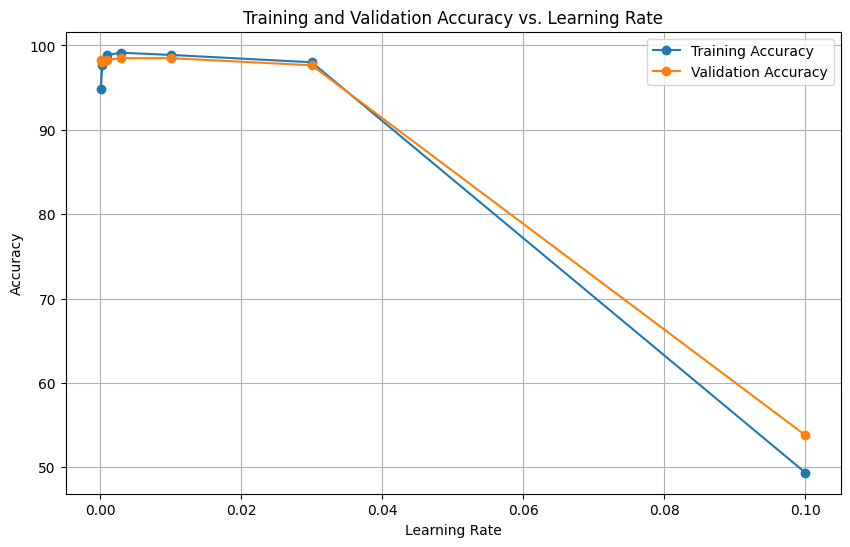

In [59]:
plt.figure(figsize=(10,6))

plt.plot(results_df['Learning Rate'], results_df['Training Accuracy'], marker='o', linestyle='-', label="Training Accuracy")

plt.plot(results_df['Learning Rate'], results_df['Validation Accuracy'], marker='o', linestyle='-', label="Validation Accuracy")

plt.xlabel('Learning Rate')

plt.ylabel('Accuracy')

plt.title('Training and Validation Accuracy vs. Learning Rate')

plt.legend()

plt.grid(True)

plt.show()


Use 5-fold cross-validation to evaluate the performance w.r.t. optimizers, you could use the feature engineering method that has the best performance from Question 1.  Recommended candidate values: [SGD, Adam, RMSprop]

In [61]:
optimizers_lst = ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'AdamW']
results = []
acc_train = []
acc_test = []
std_train = []
std_test = []

for i in optimizers_lst:
  bert_res, category_map, final_model = train_evaluate_model(X_bert, y, optimizer_name=i, num_epochs=50, batch_size=32, learning_rate=0.01)
  acc_train.append(sum(bert_res[0]) / len(bert_res[0]))
  acc_test.append(sum(bert_res[1]) / len(bert_res[1]))
  std_train.append(np.std(bert_res[0]))
  std_test.append(np.std(bert_res[1]))

results = {
            'Optimizer': optimizers_lst,
            'Training Accuracy': acc_train,
            'Standard Deviation of Training Accuracy': std_train,
            'Validation Accuracy': acc_test,
            'Standard Deviation of Validation Accuracy': std_test
          }

FOLD 1
--------------------------------
Epoch 1: Training Accuracy: 76.71%
Epoch 2: Training Accuracy: 94.35%
Epoch 3: Training Accuracy: 97.18%
Epoch 4: Training Accuracy: 98.82%
Epoch 5: Training Accuracy: 99.18%
Epoch 6: Training Accuracy: 97.65%
Epoch 7: Training Accuracy: 97.76%
Epoch 8: Training Accuracy: 99.06%
Epoch 9: Training Accuracy: 98.82%
Epoch 10: Training Accuracy: 98.24%
Epoch 11: Training Accuracy: 99.65%
Epoch 12: Training Accuracy: 99.76%
Epoch 13: Training Accuracy: 99.18%
Epoch 14: Training Accuracy: 98.35%
Epoch 15: Training Accuracy: 99.65%
Epoch 16: Training Accuracy: 99.41%
Epoch 17: Training Accuracy: 99.53%
Epoch 18: Training Accuracy: 99.76%
Epoch 19: Training Accuracy: 100.00%
Epoch 20: Training Accuracy: 100.00%
Epoch 21: Training Accuracy: 99.65%
Epoch 22: Training Accuracy: 99.88%
Epoch 23: Training Accuracy: 100.00%
Epoch 24: Training Accuracy: 100.00%
Epoch 25: Training Accuracy: 100.00%
Epoch 26: Training Accuracy: 100.00%
Epoch 27: Training Accuracy

In [62]:
results_df = pd.DataFrame(results)
display(results_df)

,Optimizer,Training Accuracy,Standard Deviation of Training Accuracy,Validation Accuracy,Standard Deviation of Validation Accuracy
0,Adam,99.108186,3.603428,97.462574,1.796124
1,SGD,77.226068,23.609053,95.579768,0.814957
2,RMSprop,96.703914,11.242896,97.834618,0.876788
3,Adagrad,98.988727,4.678183,97.930286,2.273499
4,AdamW,98.992393,3.776440,97.929400,0.766271


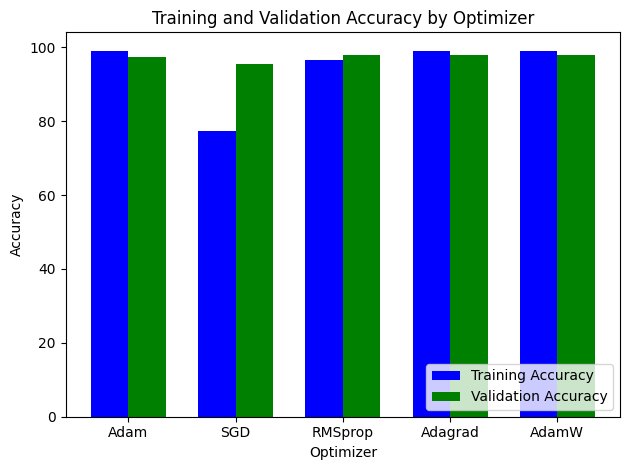

In [63]:
n_groups = len(optimizers_lst)
index = np.arange(n_groups)
bar_width = 0.35

fig, ax = plt.subplots()

rects1 = ax.bar(index, acc_train, bar_width, color='b', label='Training Accuracy')
rects2 = ax.bar(index + bar_width, acc_test, bar_width, color='g', label='Validation Accuracy')

ax.set_xlabel('Optimizer')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy by Optimizer')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(optimizers_lst)
ax.legend()

plt.tight_layout()
plt.legend(loc='lower right')

plt.show()

In [24]:
def map_predictions_to_categories(predictions, category_map):
    return category_map[predictions]

In [64]:
bert_res, category_map, final_model = train_evaluate_model(X_bert, y, optimizer_name="adamw", num_epochs=50, batch_size=32, learning_rate=0.01)

def predict_nn(new_data, model):
    final_model.eval()
    with torch.no_grad():
        inputs = torch.FloatTensor(new_data)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
    return predicted.numpy()

new_data = X_test_bert
predicted_categories = predict_nn(new_data, final_model)

categorical_predictions = map_predictions_to_categories(predicted_categories, category_map)

predictions_nn_df = pd.DataFrame({
    'ArticleId': test_df['ArticleId'],
    'Prediction': categorical_predictions
})

display(predictions_nn_df)

FOLD 1
--------------------------------
Epoch 1: Training Accuracy: 77.06%
Epoch 2: Training Accuracy: 95.06%
Epoch 3: Training Accuracy: 97.18%
Epoch 4: Training Accuracy: 98.94%
Epoch 5: Training Accuracy: 98.12%
Epoch 6: Training Accuracy: 98.24%
Epoch 7: Training Accuracy: 98.94%
Epoch 8: Training Accuracy: 98.94%
Epoch 9: Training Accuracy: 99.06%
Epoch 10: Training Accuracy: 99.29%
Epoch 11: Training Accuracy: 97.53%
Epoch 12: Training Accuracy: 99.18%
Epoch 13: Training Accuracy: 98.94%
Epoch 14: Training Accuracy: 99.65%
Epoch 15: Training Accuracy: 99.41%
Epoch 16: Training Accuracy: 97.06%
Epoch 17: Training Accuracy: 98.94%
Epoch 18: Training Accuracy: 95.88%
Epoch 19: Training Accuracy: 99.53%
Epoch 20: Training Accuracy: 98.24%
Epoch 21: Training Accuracy: 100.00%
Epoch 22: Training Accuracy: 100.00%
Epoch 23: Training Accuracy: 100.00%
Epoch 24: Training Accuracy: 100.00%
Epoch 25: Training Accuracy: 100.00%
Epoch 26: Training Accuracy: 100.00%
Epoch 27: Training Accuracy

,ArticleId,Prediction
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,politics
733,206,business


In [65]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import numpy as np

bert_embedding = X_bert
labels = y
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Defined with best parameters from previous Homework
rfc = RandomForestClassifier(max_depth=20, max_features=200, min_samples_leaf=5, min_samples_split=10, criterion='gini')
gbt = GradientBoostingClassifier(n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_features=100, max_depth=10, learning_rate=0.5)

rfc_train_scores = []
rfc_val_scores = []
gbt_train_scores = []
gbt_val_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(bert_embeddings)):
    X_train, X_test = bert_embeddings[train_index], bert_embeddings[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    rfc.fit(X_train, y_train)
    gbt.fit(X_train, y_train)

    rfc_train_pred = rfc.predict(X_train)
    gbt_train_pred = gbt.predict(X_train)

    rfc_test_pred = rfc.predict(X_test)
    gbt_test_pred = gbt.predict(X_test)

    rfc_train_accuracy = accuracy_score(y_train, rfc_train_pred)
    gbt_train_accuracy = accuracy_score(y_train, gbt_train_pred)

    rfc_test_accuracy = accuracy_score(y_test, rfc_test_pred)
    gbt_test_accuracy = accuracy_score(y_test, gbt_test_pred)

    rfc_train_scores.append(rfc_train_accuracy)
    rfc_val_scores.append(rfc_test_accuracy)

    gbt_train_scores.append(gbt_train_accuracy)
    gbt_val_scores.append(gbt_test_accuracy)

    print(f'Fold {fold + 1}')
    print(f'Random Forest - Train Accuracy: {rfc_train_accuracy:.2%}, Validation Accuracy: {rfc_test_accuracy:.2%}')
    print(f'Gradient Boosting - Train Accuracy: {gbt_train_accuracy:.2%}, Validation Accuracy: {gbt_test_accuracy:.2%}')
    print('---')

rfc_avg_train_accuracy = np.mean(rfc_train_scores)
rfc_avg_val_accuracy = np.mean(rfc_val_scores)

gbt_avg_train_accuracy = np.mean(gbt_train_scores)
gbt_avg_val_accuracy = np.mean(gbt_val_scores)

print('Summary:')
print(f'Random Forest - Average Train Accuracy: {rfc_avg_train_accuracy:.2%}, Average Validation Accuracy: {rfc_avg_val_accuracy:.2%}')
print(f'Gradient Boosting - Average Train Accuracy: {gbt_avg_train_accuracy:.2%}, Average Validation Accuracy: {gbt_avg_val_accuracy:.2%}')



Fold 1
Random Forest - Train Accuracy: 99.65%, Validation Accuracy: 97.65%
Gradient Boosting - Train Accuracy: 100.00%, Validation Accuracy: 97.18%
---
Fold 2
Random Forest - Train Accuracy: 99.65%, Validation Accuracy: 94.37%
Gradient Boosting - Train Accuracy: 100.00%, Validation Accuracy: 97.18%
---
Fold 3
Random Forest - Train Accuracy: 99.88%, Validation Accuracy: 97.18%
Gradient Boosting - Train Accuracy: 100.00%, Validation Accuracy: 96.71%
---
Fold 4
Random Forest - Train Accuracy: 99.76%, Validation Accuracy: 97.64%
Gradient Boosting - Train Accuracy: 100.00%, Validation Accuracy: 96.70%
---
Fold 5
Random Forest - Train Accuracy: 99.88%, Validation Accuracy: 97.17%
Gradient Boosting - Train Accuracy: 100.00%, Validation Accuracy: 95.75%
---
Summary:
Random Forest - Average Train Accuracy: 99.76%, Average Validation Accuracy: 96.80%
Gradient Boosting - Average Train Accuracy: 100.00%, Average Validation Accuracy: 96.71%


In [66]:
rfc_full = RandomForestClassifier(max_depth=20, max_features=200, min_samples_leaf=5, min_samples_split=10, criterion='gini')
gbt_full = GradientBoostingClassifier(n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_features=100, max_depth=10, learning_rate=0.5)


rfc_full.fit(X_bert, y)
gbt_full.fit(X_bert, y)

rfc_predictions = rfc_full.predict(X_test_bert)
gbt_predictions = gbt_full.predict(X_test_bert)

In [67]:
predictions_df = pd.DataFrame({
    'rfc': rfc_predictions,
    'gbt': gbt_predictions,
    'nn': categorical_predictions
})

display(predictions_df)


,rfc,gbt,nn
0,sport,sport,sport
1,tech,tech,tech
2,sport,sport,sport
3,business,business,business
4,sport,sport,sport
...,...,...,...
730,business,business,business
731,entertainment,entertainment,entertainment
732,politics,politics,politics
733,business,business,business


In [68]:
# Implementing Ensemble Hard Voting by taking into consideration the results of three models: RandomForestClassifier, GradientBoostingClassifier and Neural Network

import pandas as pd
from collections import Counter

def ensemble_hard_voting(row):
    vote_counts = Counter(row)
    freq, num_freq = vote_counts.most_common(1)[0]
    return freq

voted_predictions = predictions_df.apply(ensemble_hard_voting, axis=1)


test_df['Prediction'] = voted_predictions

test_df[['ArticleId', 'Prediction']].to_csv("labels.csv", header=False, index=False)
